## EV Charging Location Analysis Using US Census Data <br>
### Goal: Retrieve demographic data (income, age, education, ethnicity) from the ACS 5-Year API, clean, explore, and prepare for analysis.

In [2]:
# Setup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For geospatial mapping
#import geopandas as gpd
#from shapely.geometry import Point

In [ ]:
# Set your Census API key (register here: https://api.census.gov/data/key_signup.html)
#CENSUS_API_KEY = "0b0513fe67b0e2da1250859200feb24c65be5558"
#BASE_URL = "https://api.census.gov/data/2022/acs/acs5"



In [22]:
# ==============================
# CONFIG
# ==============================
API_KEY = "0b0513fe67b0e2da1250859200feb24c65be5558"
STATE_FIPS = "17"  # Illinois
YEARS = ["2021", "2022", "2023"]

# Variables (counts only) - Added Total Population
VARIABLES_COUNTS = [
    # Total Population
    "DP05_0001E",
    # Income
    "DP03_0062E","DP03_0052E","DP03_0053E","DP03_0054E","DP03_0055E",
    "DP03_0056E","DP03_0057E","DP03_0058E","DP03_0059E","DP03_0060E",
    "DP03_0061E",
    # Age
    "DP02_0014E","DP02_0015E","DP02_0016E","DP02_0017E","DP02_0018E",
    "DP02_0019E","DP02_0020E","DP02_0021E","DP02_0022E","DP02_0023E",
    "DP02_0024E","DP02_0025E","DP02_0026E",
    # Education
    "DP02_0062E","DP02_0063E","DP02_0064E","DP02_0065E","DP02_0066E",
    "DP02_0067E","DP02_0068E",
    # Race/Ethnicity
    "DP05_0037E","DP05_0038E","DP05_0039E","DP05_0044E","DP05_0052E",
    "DP05_0057E","DP05_0058E","DP05_0071E","DP05_0072E"
]

# Human-readable mapping for major variables
COL_RENAME = {
    "NAME": "Geography",
    "DP05_0001E": "Total_Population",
    "DP03_0062E": "Median_HH_Income",
    "DP03_0052E": "HH_Income_<10k",
    "DP03_0053E": "HH_Income_10k_14k",
    "DP03_0054E": "HH_Income_15k_24k",
    "DP03_0055E": "HH_Income_25k_34k",
    "DP03_0056E": "HH_Income_35k_49k",
    "DP03_0057E": "HH_Income_50k_74k",
    "DP03_0058E": "HH_Income_75k_99k",
    "DP03_0059E": "HH_Income_100k_149k",
    "DP03_0060E": "HH_Income_150k_199k",
    "DP03_0061E": "HH_Income_200k_plus",
    "DP02_0014E": "Age_Under_5",
    "DP02_0015E": "Age_5_9",
    "DP02_0016E": "Age_10_14",
    "DP02_0017E": "Age_15_19",
    "DP02_0018E": "Age_20_24",
    "DP02_0019E": "Age_25_34",
    "DP02_0020E": "Age_35_44",
    "DP02_0021E": "Age_45_54",
    "DP02_0022E": "Age_55_59",
    "DP02_0023E": "Age_60_64",
    "DP02_0024E": "Age_65_74",
    "DP02_0025E": "Age_75_84",
    "DP02_0026E": "Age_85_plus",
    "DP02_0062E": "Edu_Less_9th",
    "DP02_0063E": "Edu_9_12_NoDiploma",
    "DP02_0064E": "Edu_HS_Grad",
    "DP02_0065E": "Edu_SomeCollege",
    "DP02_0066E": "Edu_Associate",
    "DP02_0067E": "Edu_Bachelors",
    "DP02_0068E": "Edu_Graduate",
    "DP05_0037E": "Race_White",
    "DP05_0038E": "Race_Black",
    "DP05_0039E": "Race_AmericanIndian",
    "DP05_0044E": "Race_Asian",
    "DP05_0052E": "Race_NativeHawaiian",
    "DP05_0057E": "Race_Other",
    "DP05_0058E": "Race_TwoOrMore",
    "DP05_0071E": "Ethn_Hispanic",
    "DP05_0072E": "Ethn_NonHispanic"
}

# ==============================
# MULTI-YEAR DATA PULL
# ==============================
county_all = []
zcta_all = []

for yr in YEARS:
    print(f"Pulling data for {yr}...")

    base_url = f"https://api.census.gov/data/{yr}/acs/acs5/profile"

    # ---- COUNTY DATA ----
    params_county = {
        "get": ",".join(["NAME"] + VARIABLES_COUNTS),
        "for": "county:*",
        "in": f"state:{STATE_FIPS}",
        "key": API_KEY
    }
    resp = requests.get(base_url, params=params_county)
    resp.raise_for_status()
    data = resp.json()
    df_county = pd.DataFrame(columns=data[0], data=data[1:])
    df_county.rename(columns=lambda x: COL_RENAME.get(x, x), inplace=True)
    df_county["Year"] = yr
    county_all.append(df_county)

    # ---- ZCTA DATA ----
    params_zcta = {
        "get": ",".join(["NAME"] + VARIABLES_COUNTS),
        "for": "zip code tabulation area:*",
        "key": API_KEY
    }
    resp = requests.get(base_url, params=params_zcta)
    resp.raise_for_status()
    data = resp.json()
    df_zcta = pd.DataFrame(columns=data[0], data=data[1:])
    df_zcta.rename(columns=lambda x: COL_RENAME.get(x, x), inplace=True)
    df_zcta["Year"] = yr

    # Illinois ZIP filter (prefix method: 60xxx, 61xxx, 62xxx)
    df_zcta = df_zcta[df_zcta['zip code tabulation area'].str.startswith(('60', '61', '62'))]

    zcta_all.append(df_zcta)

# Combine all years
county_df = pd.concat(county_all, ignore_index=True)
zcta_df = pd.concat(zcta_all, ignore_index=True)

print("✅ Pull complete:")
print("  County DF shape:", county_df.shape)
print("  ZCTA DF shape:", zcta_df.shape)

# ==============================
# SAVE FINAL COMBINED CSVs
# ==============================
county_df.to_csv("il_census_county_counts_2021_2023.csv", index=False)
zcta_df.to_csv("il_census_zcta_counts_2021_2023.csv", index=False)

print("✅ Multi-year combined files saved successfully.")


Pulling data for 2021...
Pulling data for 2022...
Pulling data for 2023...
✅ Pull complete:
  County DF shape: (306, 45)
  ZCTA DF shape: (4188, 44)
✅ Multi-year combined files saved successfully.


In [6]:
# Load your saved data
#county_df = pd.read_csv("il_census_county_counts_2021_2023.csv", dtype=str)
#zcta_df = pd.read_csv("il_census_zcta_counts_2021_2023.csv", dtype=str)

In [11]:
# edit df view settings to display all columns
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', 2000)         # Set a large width
pd.set_option('display.max_colwidth', None)  # Don't truncate column contents

In [42]:
county_df.sample(10)


,Geography,Total_Population,Median_HH_Income,HH_Income_<10k,HH_Income_10k_14k,HH_Income_15k_24k,HH_Income_25k_34k,HH_Income_35k_49k,HH_Income_50k_74k,HH_Income_75k_99k,HH_Income_100k_149k,HH_Income_150k_199k,HH_Income_200k_plus,Age_Under_5,Age_5_9,Age_10_14,Age_15_19,Age_20_24,Age_25_34,Age_35_44,Age_45_54,Age_55_59,Age_60_64,Age_65_74,Age_75_84,Age_85_plus,Edu_Less_9th,Edu_9_12_NoDiploma,Edu_HS_Grad,Edu_SomeCollege,Edu_Associate,Edu_Bachelors,Edu_Graduate,Race_White,Race_Black,Race_AmericanIndian,Race_Asian,Race_NativeHawaiian,Race_Other,Race_TwoOrMore,Ethn_Hispanic,Ethn_NonHispanic,state,county,Year
2,"Bond County, Illinois","16,804.00",53654,503,261,596,519,940,1119,801,868,312,175,1847,2173,2.43,3.06,14825,6094,3015,265,4064,755,632,7533,3057,3916,2935,1239,1523,1011,10624,2534,15120,1184,112,165,0,36,187,630,403,17,005,2021
95,"Wayne County, Illinois","16,250.00",51540,323,392,915,688,1003,1300,997,756,299,123,2094,2527,2.38,2.92,16183,6796,3609,378,4681,475,244,6522,1624,3967,2418,1843,1177,559,9964,1736,15685,183,14,51,0,199,118,263,57,17,191,2021
286,"Saline County, Illinois","23,387.00",54945,559,623,1001,1017,1169,1912,1297,1344,547,563,2801,3627,2.28,2.83,22875,10032,4589,622,5854,1180,598,9383,2719,5208,4030,2432,2463,983,15116,3446,21617,654,20,0,42,11,0,255,217,17,165,2023
300,"White County, Illinois","13,708.00",53097,401,390,624,419,854,963,734,707,358,219,1511,2135,2.36,2.99,13357,5669,2633,318,3859,544,334,5470,1500,3393,2207,1474,958,516,8548,1474,13196,90,5,0,8,0,0,97,105,17,193,2023
89,"Tazewell County, Illinois","131,977.00",68860,2419,1820,3906,4226,7076,10022,7739,9476,4080,2955,15091,16756,2.41,2.99,129397,53719,27835,3545,37027,4228,3043,52610,15959,28037,21773,10746,17543,8014,86113,25557,125466,1762,121,1375,62,420,2771,3258,2435,17,179,2021
81,"St. Clair County, Illinois","258,597.00",63017,6757,4127,9293,8508,12624,17392,13001,14847,7822,5708,29246,29136,2.55,3.25,254756,100079,44225,5728,80229,18157,6338,99429,35811,48222,43596,18710,30619,21664,162811,52283,161899,75455,358,3813,97,3915,13060,11248,7019,17,163,2021
0,"Adams County, Illinois","65,878.00",58587,1375,923,2714,2631,3889,5213,3941,3979,1407,1102,7343,9088,2.38,2.99,64574,27174,13309,1873,18024,2784,1410,25944,7908,16058,10307,4332,7837,3973,42507,11810,60689,2615,51,420,8,153,1942,1146,637,17,001,2021
47,"Knox County, Illinois","50,193.00",45994,1852,1220,2692,2088,3021,3610,2510,2340,766,476,4906,7718,2.23,2.94,45814,20575,8649,1629,12244,1633,1084,21217,8569,12274,7747,4149,4562,2293,31025,6855,42575,4416,45,518,0,945,1694,3070,2271,17,095,2021
171,"Moultrie County, Illinois","14,531.00",72833,249,164,502,492,579,1004,1010,1158,304,362,1845,1893,2.44,2.95,14182,5824,3264,370,4363,236,125,5637,1498,3177,2303,927,1365,659,8431,2024,13997,147,1,21,0,94,271,209,14531,17,139,2022
220,"Crawford County, Illinois","18,588.00",67614,459,344,711,550,595,1500,950,1199,761,342,2140,2519,2.31,2.85,17101,7411,3978,436,4503,449,324,8280,2748,3988,2894,2273,1939,859,11953,2798,16942,656,220,0,0,0,0,585,135,17,033,2023


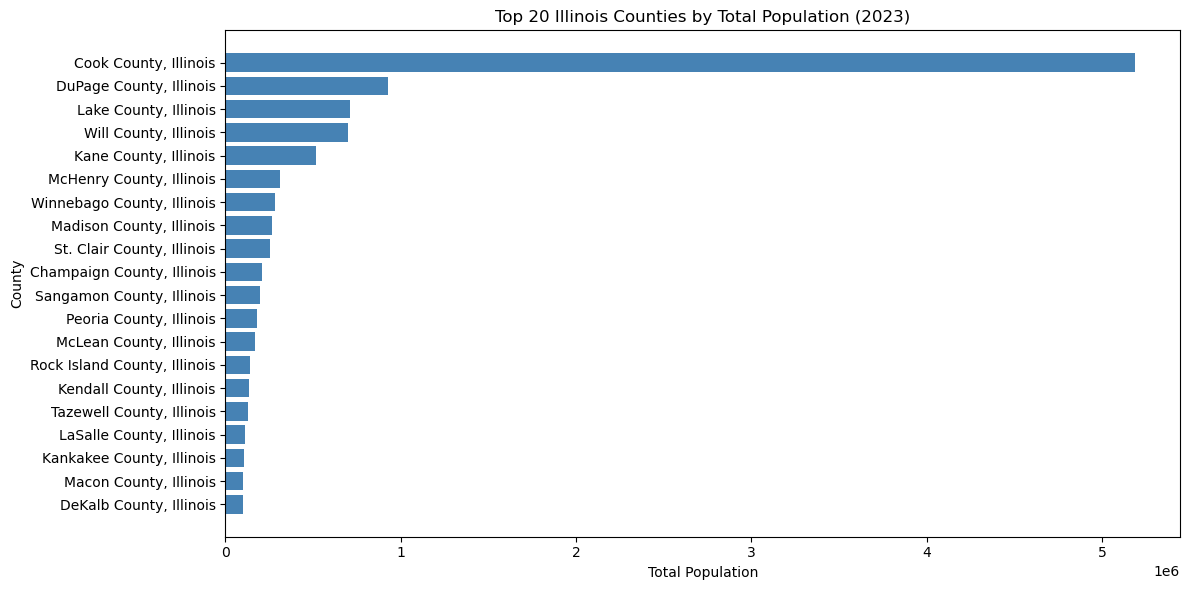

In [33]:
# Filter to 2023 only
county_2023 = county_df[county_df["Year"] == "2023"].copy()

# Ensure numeric values
county_2023["Total_Population"] = (
    county_2023["Total_Population"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace("", None)
    .astype(float)
)

# Get top 20 counties
top_20_pop = county_2023.sort_values(by="Total_Population", ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_20_pop["Geography"], top_20_pop["Total_Population"], color='steelblue')
plt.xlabel("Total Population")
plt.ylabel("County")
plt.title("Top 20 Illinois Counties by Total Population (2023)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


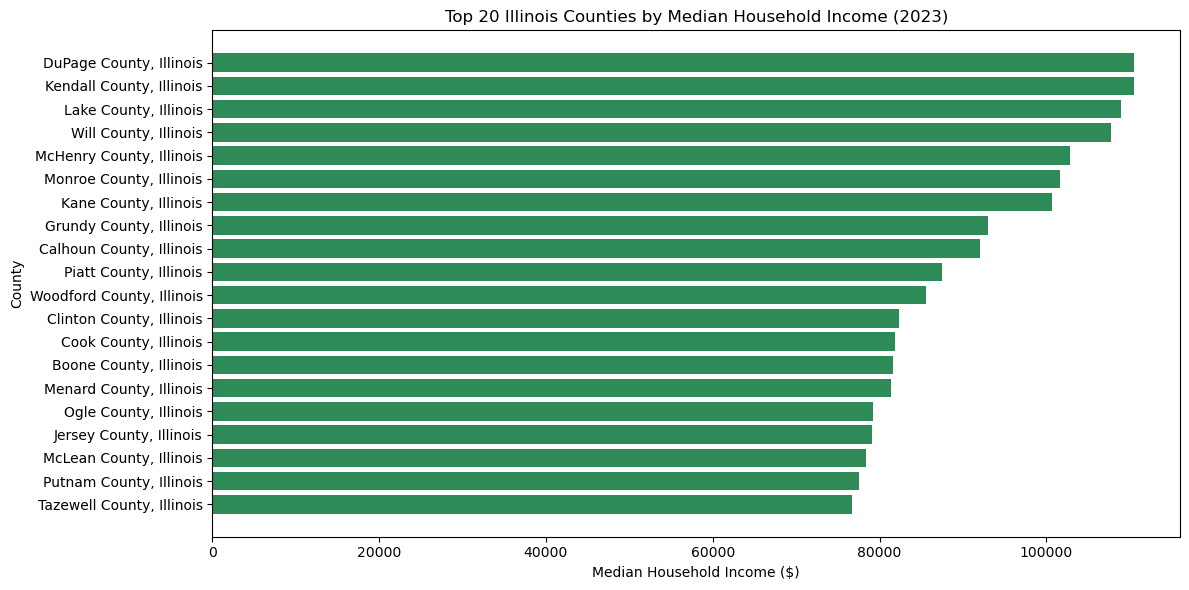

In [34]:
# Filter to 2023 only
county_2023 = county_df[county_df["Year"] == "2023"].copy()

# Convert Median_HH_Income to numeric
county_2023["Median_HH_Income"] = (
    county_2023["Median_HH_Income"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace("", None)
    .astype(float)
)

# Get top 20 counties
top_20_income = county_2023.sort_values(by="Median_HH_Income", ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_20_income["Geography"], top_20_income["Median_HH_Income"], color='seagreen')
plt.xlabel("Median Household Income ($)")
plt.ylabel("County")
plt.title("Top 20 Illinois Counties by Median Household Income (2023)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


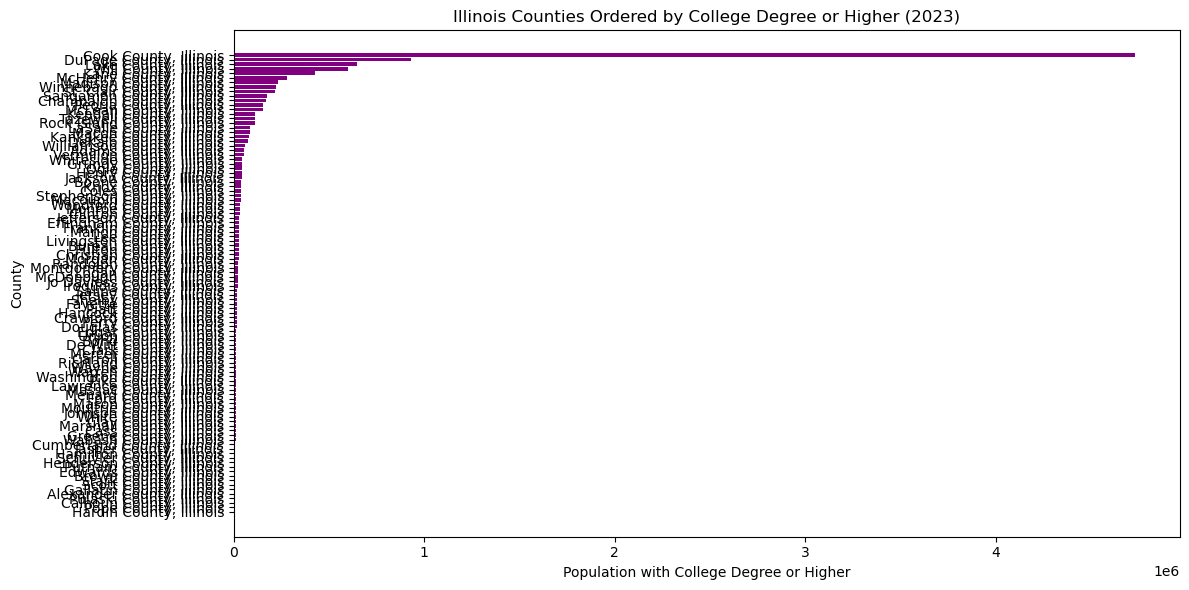

In [36]:
# Filter to 2023 only
top_edu_2023 = demo_county_df[demo_county_df["Year"] == "2023"].copy()

# Ensure numeric conversion for the education field
top_edu_2023["College_Degree_or_Higher"] = (
    top_edu_2023["College_Degree_or_Higher"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace("", None)
    .astype(float)
)

# Sort counties by population with college degree or higher
top_edu_2023 = top_edu_2023.sort_values(by="College_Degree_or_Higher", ascending=False)

# Plot
plt.figure(figsize=(12,6))
plt.barh(top_edu_2023["Geography"], top_edu_2023["College_Degree_or_Higher"], color='purple')
plt.xlabel("Population with College Degree or Higher")
plt.ylabel("County")
plt.title("Illinois Counties Ordered by College Degree or Higher (2023)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


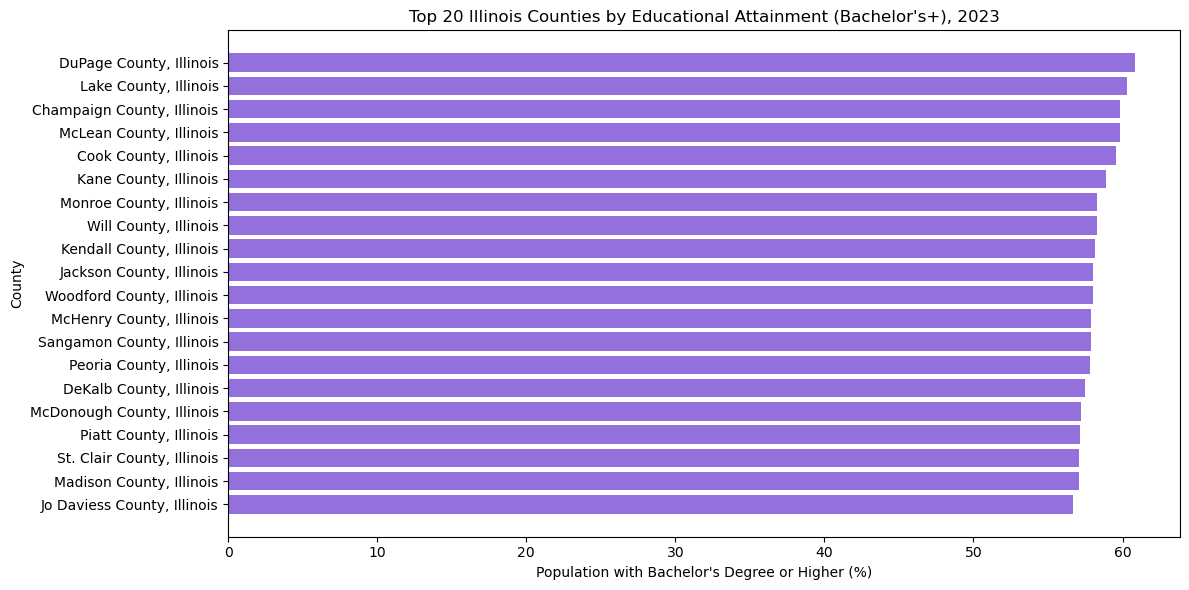

In [35]:
# Filter to 2023 data
county_2023 = county_df[county_df["Year"] == "2023"].copy()

# Convert relevant education columns to numeric
edu_cols = ["Edu_Bachelors", "Edu_Graduate", "Edu_Less_9th", "Edu_9_12_NoDiploma", 
            "Edu_HS_Grad", "Edu_SomeCollege", "Edu_Associate"]

for col in edu_cols:
    county_2023[col] = (
        county_2023[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .replace("", None)
        .astype(float)
    )

# Calculate population with reported education (age 25+)
county_2023["Edu_Total"] = county_2023[edu_cols].sum(axis=1)

# Calculate % of population with Bachelor's degree or higher
county_2023["Pct_BachelorsPlus"] = (
    (county_2023["Edu_Bachelors"] + county_2023["Edu_Graduate"])
    / county_2023["Edu_Total"]
) * 100

# Sort and get top 20 counties
top_20_edu = county_2023.sort_values(by="Pct_BachelorsPlus", ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_20_edu["Geography"], top_20_edu["Pct_BachelorsPlus"], color='mediumpurple')
plt.xlabel("Population with Bachelor's Degree or Higher (%)")
plt.ylabel("County")
plt.title("Top 20 Illinois Counties by Educational Attainment (Bachelor's+), 2023")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [41]:
# --- Pivot to get population for both years ---
growth_pivot = growth_df.pivot_table(
    index="Geography",
    columns="Year",
    values="Total_Population",
    aggfunc="sum"
).reset_index()

# ✅ Drop the "Year" name from columns
growth_pivot.columns.name = None

# --- Rename columns ---
growth_pivot.rename(columns={
    "2021": "Pop_2021",
    "2023": "Pop_2023"
}, inplace=True)

# --- Convert to integers where possible ---
growth_pivot["Pop_2021"] = growth_pivot["Pop_2021"].astype("Int64")
growth_pivot["Pop_2023"] = growth_pivot["Pop_2023"].astype("Int64")

# --- Calculate growth % ---
growth_pivot["Pop_Growth_%"] = (
    (growth_pivot["Pop_2023"] - growth_pivot["Pop_2021"]) / growth_pivot["Pop_2021"] * 100
).round(2)

# --- Sort and reset index cleanly ---
top_growth = growth_pivot.sort_values(by="Pop_Growth_%", ascending=False).head(10).reset_index(drop=True)

print("Top 10 Illinois Counties by Population Growth (2021–2023):")
display(top_growth)


Top 10 Illinois Counties by Population Growth (2021–2023):


,Geography,Pop_2021,Pop_2023,Pop_Growth_%
0,"Kendall County, Illinois",130757,135053,3.29
1,"Grundy County, Illinois",52364,52920,1.06
2,"Johnson County, Illinois",13238,13350,0.85
3,"Monroe County, Illinois",34732,34969,0.68
4,"Will County, Illinois",696403,698450,0.29
5,"Piatt County, Illinois",16664,16702,0.23
6,"Carroll County, Illinois",15586,15621,0.22
7,"McHenry County, Illinois",310749,311366,0.20
8,"Douglas County, Illinois",19708,19686,-0.11
9,"Brown County, Illinois",6330,6320,-0.16


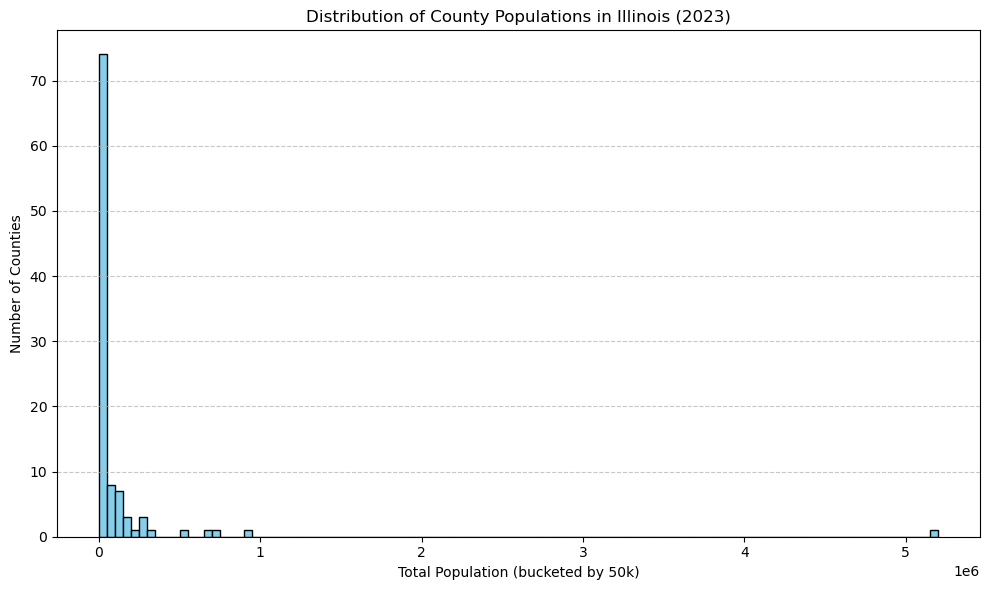

In [47]:

# Filter to 2023 data only
county_2023 = county_df[county_df["Year"] == "2023"].copy()
county_2023["Total_Population"] = county_2023["Total_Population"].astype(int)

# Determine min and max for bins
pop_min = county_2023["Total_Population"].min()
pop_max = county_2023["Total_Population"].max()

# Define bins (increments of 50k)
bin_size = 50000
bins = range(0, int(pop_max) + bin_size, bin_size)

# Create histogram
plt.figure(figsize=(10,6))
plt.hist(county_2023["Total_Population"], bins=bins, color='skyblue', edgecolor='black')
plt.title("Distribution of County Populations in Illinois (2023)")
plt.xlabel("Total Population (bucketed by 50k)")
plt.ylabel("Number of Counties")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


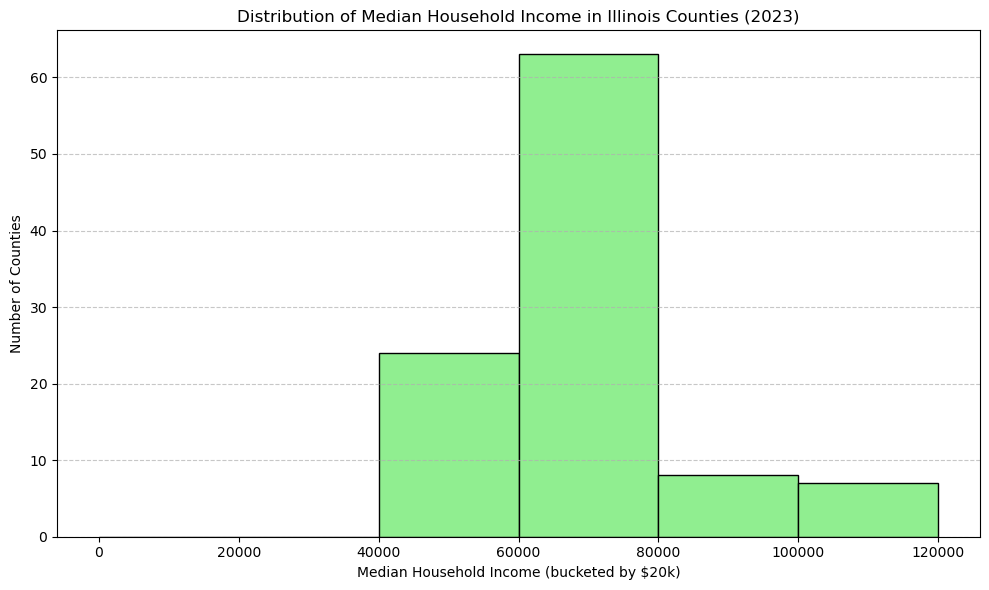

In [48]:
# Filter to 2023 data
county_2023 = county_df[county_df["Year"] == "2023"].copy()
county_2023["Median_HH_Income"] = county_2023["Median_HH_Income"].astype(float)

# Determine min and max values
income_min = county_2023["Median_HH_Income"].min()
income_max = county_2023["Median_HH_Income"].max()

# Define bins ($20k increments)
bin_size = 20000
bins = range(0, int(income_max) + bin_size, bin_size)

# Create histogram
plt.figure(figsize=(10,6))
plt.hist(county_2023["Median_HH_Income"], bins=bins, color='lightgreen', edgecolor='black')
plt.title("Distribution of Median Household Income in Illinois Counties (2023)")
plt.xlabel("Median Household Income (bucketed by $20k)")
plt.ylabel("Number of Counties")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [54]:
# Filter to 2023
county_2023 = county_df[county_df["Year"] == "2023"].copy()

# Define ethnicity columns
ethnicity_cols = [
    "Race_White","Race_Black","Race_AmericanIndian","Race_Asian",
    "Race_NativeHawaiian","Race_Other","Race_TwoOrMore"
]

# --- 0️⃣ Identify non-numeric data issues ---
problematic_entries = {}
for col in ethnicity_cols:
    # Find non-numeric rows
    non_numeric = county_2023[~county_2023[col].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
    if not non_numeric.empty:
        problematic_entries[col] = non_numeric[["Geography", col]].head(10)  # show first 10 for inspection

# Print problematic rows if any
if problematic_entries:
    print("⚠️ Non-numeric values detected in ethnicity columns:")
    for col, df_ in problematic_entries.items():
        print(f"\nColumn: {col}")
        display(df_)
else:
    print("✅ No non-numeric values detected. Proceeding with numeric conversion.")

# --- 1️⃣ Convert ethnicity columns to numeric ---
for col in ethnicity_cols:
    county_2023[col] = pd.to_numeric(county_2023[col], errors='coerce').fillna(0)

# --- 2️⃣ Cook County ---
cook_ethnicity = county_2023[county_2023["Geography"] == "Cook County, Illinois"][ethnicity_cols].sum()

# --- 3️⃣ All other counties ---
other_ethnicity = county_2023[county_2023["Geography"] != "Cook County, Illinois"][ethnicity_cols].sum()

# --- 4️⃣ Combine into one DataFrame for side-by-side comparison ---
ethnicity_comparison = pd.DataFrame({
    "Cook County": cook_ethnicity,
    "All Other Counties": other_ethnicity
}).reset_index().rename(columns={"index": "Ethnicity"})

display(ethnicity_comparison)


✅ No non-numeric values detected. Proceeding with numeric conversion.


,Ethnicity,Cook County,All Other Counties
0,Race_White,2408676,5629836
1,Race_Black,1165825,584589
2,Race_AmericanIndian,38507,28483
3,Race_Asian,300,316
4,Race_NativeHawaiian,34732,21142
5,Race_Other,1116,1125
6,Race_TwoOrMore,527,553


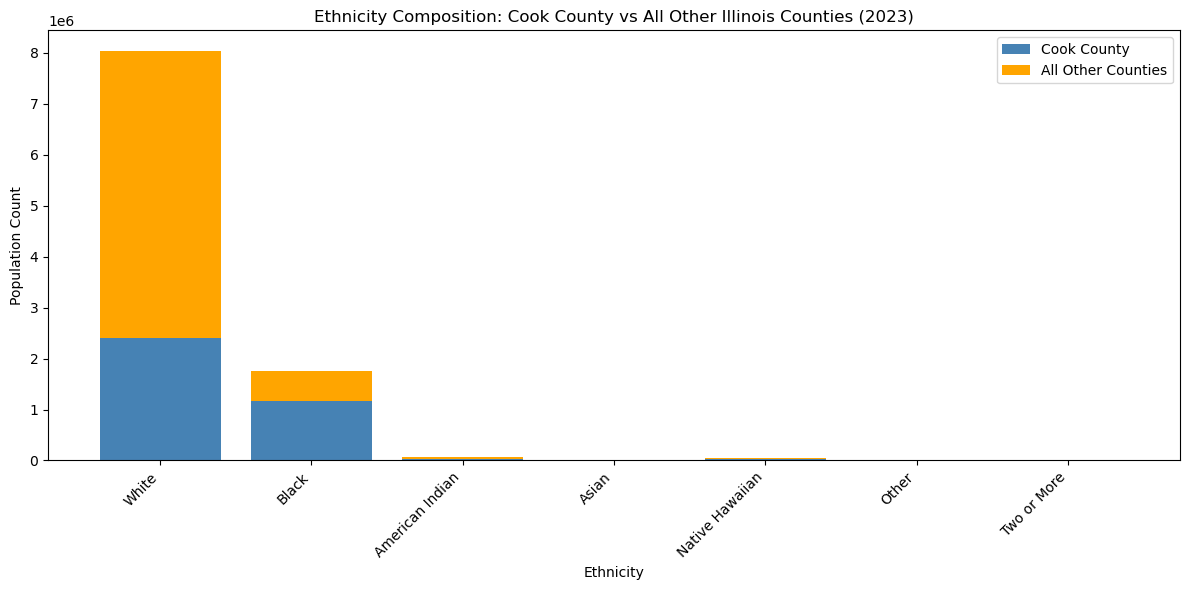

In [55]:

# --- Rename ethnicity labels ---
label_map = {
    "Race_White": "White",
    "Race_Black": "Black",
    "Race_AmericanIndian": "American Indian",
    "Race_Asian": "Asian",
    "Race_NativeHawaiian": "Native Hawaiian",
    "Race_Other": "Other",
    "Race_TwoOrMore": "Two or More"
}

ethnicity_comparison['Ethnicity'] = ethnicity_comparison['Ethnicity'].map(label_map)

# --- Prepare data ---
x = ethnicity_comparison['Ethnicity']
cook = ethnicity_comparison['Cook County']
others = ethnicity_comparison['All Other Counties']

# --- Plot stacked bar chart ---
plt.figure(figsize=(12, 6))
plt.bar(x, cook, label='Cook County', color='steelblue')
plt.bar(x, others, bottom=cook, label='All Other Counties', color='orange')

# --- Labels and title ---
plt.xlabel("Ethnicity")
plt.ylabel("Population Count")
plt.title("Ethnicity Composition: Cook County vs All Other Illinois Counties (2023)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
